In [1]:
from google.colab import files

uploaded = files.upload()

Saving prc-pfa-mar2013-onwards-tables-191023 (1).xlsx to prc-pfa-mar2013-onwards-tables-191023 (1).xlsx


In [9]:
pip install r- requirements.txt

In [8]:
file_name = list(uploaded.keys())[0]
file_path = '/content/' + file_name

prc = pd.read_excel(file_path)

In [3]:
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pyarrow.parquet as pq
import pyarrow as pa
import warnings
import gc, sys
warnings.filterwarnings('ignore')

**Data Cleaning**

Read the sheet name in the ods file without reading the data.

In [10]:
data_path = file_path
xls = pd.ExcelFile(data_path) #get the sheet names without reading the data
sheet_names = xls.sheet_names

print("sheet Names:", sheet_names)

sheet Names: ['Cover_sheet', 'Notes_', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24']


In [11]:
def extract_excel_sheet(data_path, start_sheet_index, end_sheet_index, parquet_file):
    xls = pd.ExcelFile(data_path)

    sheet_names = xls.sheet_names[start_sheet_index-1:end_sheet_index]

    merged_data = pd.DataFrame()

    for sheet_name in sheet_names:
        df = pd.read_excel(xls, sheet_name)

        merged_data = pd.concat([merged_data, df], ignore_index=True)
        merged_data["Offence Code"] = merged_data["Offence Code"].astype(str)

    table = pa.Table.from_pandas(merged_data)
    pa.parquet.write_table(table, parquet_file)

    print(f"Conversion completed. parquet file saved at {parquet_file}")


In [12]:
data_path = file_path
start_sheet_index = 3
end_sheet_index = 14
parquet_file = "Police_recorded_crime.pq"

extract_excel_sheet(data_path, start_sheet_index, end_sheet_index, parquet_file)

Conversion completed. parquet file saved at Police_recorded_crime.pq


In [6]:
prc = pd.read_parquet("C:/Users/admin/Documents/GitHub/Data-Science-Projects/Uk-Crime-Predictive-analysis/data/Police_recorded_crime.pq")


In [7]:
prc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258905 entries, 0 to 258904
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Financial Year       258905 non-null  object
 1   Financial Quarter    258905 non-null  int64 
 2   Force Name           258905 non-null  object
 3   Offence Description  258905 non-null  object
 4   Offence Group        258905 non-null  object
 5   Offence Subgroup     258905 non-null  object
 6   Offence Code         258905 non-null  object
 7   Number of Offences   258905 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 15.8+ MB


In [8]:
prc.shape

(258905, 8)

In [9]:
data = prc #make a copy

In [10]:
column_mapping = {}

for old_column in data.columns:
    new_column = old_column.replace(' ','-').replace('-','_')

    column_mapping[old_column] = new_column

data = data.rename(columns=column_mapping)

print(data.select_dtypes(include='object').nunique())

Financial_Year          12
Force_Name              49
Offence_Description    201
Offence_Group           10
Offence_Subgroup        31
Offence_Code           190
dtype: int64


In [11]:
print(f"Information on the data: {data.info()}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258905 entries, 0 to 258904
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Financial_Year       258905 non-null  object
 1   Financial_Quarter    258905 non-null  int64 
 2   Force_Name           258905 non-null  object
 3   Offence_Description  258905 non-null  object
 4   Offence_Group        258905 non-null  object
 5   Offence_Subgroup     258905 non-null  object
 6   Offence_Code         258905 non-null  object
 7   Number_of_Offences   258905 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 15.8+ MB
Information on the data: None


In [12]:
data.describe()

,Financial_Quarter,Number_of_Offences
count,258905.000000,258905.000000
mean,2.463031,229.901837
std,1.128399,1724.363276
min,1.000000,-268.000000
25%,1.000000,0.000000
50%,2.000000,9.000000
75%,3.000000,83.000000
max,4.000000,132693.000000


In [13]:
data['Financial_Year'] = data['Financial_Year'].str.extract(r'(\d{4})', expand=False)
data['Financial_Year'] = pd.to_datetime(data['Financial_Year'], format='%Y')
data['Financial_Year'] = data['Financial_Year'].dt.strftime('%Y')

data.head()

,Financial_Year,Financial_Quarter,Force_Name,Offence_Description,Offence_Group,Offence_Subgroup,Offence_Code,Number_of_Offences
0,2012,1,Action Fraud,Fraud offences recorded by Action Fraud,Fraud offences,Fraud: Action Fraud,AF,20323
1,2012,1,Avon and Somerset,Abandoning child under two years (outcomes only),Violence against the person,Violence without injury,12,0
2,2012,1,Avon and Somerset,Absconding from lawful custody,Miscellaneous crimes against society,Miscellaneous crimes against society,80,1
3,2012,1,Avon and Somerset,Abuse of children through prostitution and por...,Sexual offences,Other sexual offences,71,0
4,2012,1,Avon and Somerset,Abuse of position of trust of a sexual nature,Sexual offences,Other sexual offences,73,3


In [14]:
data.groupby('Offence_Subgroup')['Force_Name'].value_counts()

Offence_Subgroup         Force_Name              
Arson                    Avon and Somerset            90
                         Bedfordshire                 90
                         British Transport Police     90
                         Cambridgeshire               90
                         Cheshire                     90
                                                    ... 
Violence without injury  Warwickshire                454
                         West Mercia                 454
                         West Midlands               454
                         West Yorkshire              454
                         Wiltshire                   454
Name: Force_Name, Length: 1150, dtype: int64

**Exploratory Data analysis**

In [15]:
data['years'] = pd.to_datetime(data['Financial_Year']).dt.year
data['years'] = data['years'].astype(str)
data.head()

,Financial_Year,Financial_Quarter,Force_Name,Offence_Description,Offence_Group,Offence_Subgroup,Offence_Code,Number_of_Offences,years
0,2012,1,Action Fraud,Fraud offences recorded by Action Fraud,Fraud offences,Fraud: Action Fraud,AF,20323,2012
1,2012,1,Avon and Somerset,Abandoning child under two years (outcomes only),Violence against the person,Violence without injury,12,0,2012
2,2012,1,Avon and Somerset,Absconding from lawful custody,Miscellaneous crimes against society,Miscellaneous crimes against society,80,1,2012
3,2012,1,Avon and Somerset,Abuse of children through prostitution and por...,Sexual offences,Other sexual offences,71,0,2012
4,2012,1,Avon and Somerset,Abuse of position of trust of a sexual nature,Sexual offences,Other sexual offences,73,3,2012


In [16]:
data.groupby('Offence_Group')['Number_of_Offences'].count()

Offence_Group
Criminal damage and arson               14564
Drug offences                            7920
Fraud offences                           1543
Miscellaneous crimes against society    49104
Possession of weapons offences          11880
Public order offences                    8624
Robbery                                  3960
Sexual offences                         45056
Theft offences                          54780
Violence against the person             61474
Name: Number_of_Offences, dtype: int64

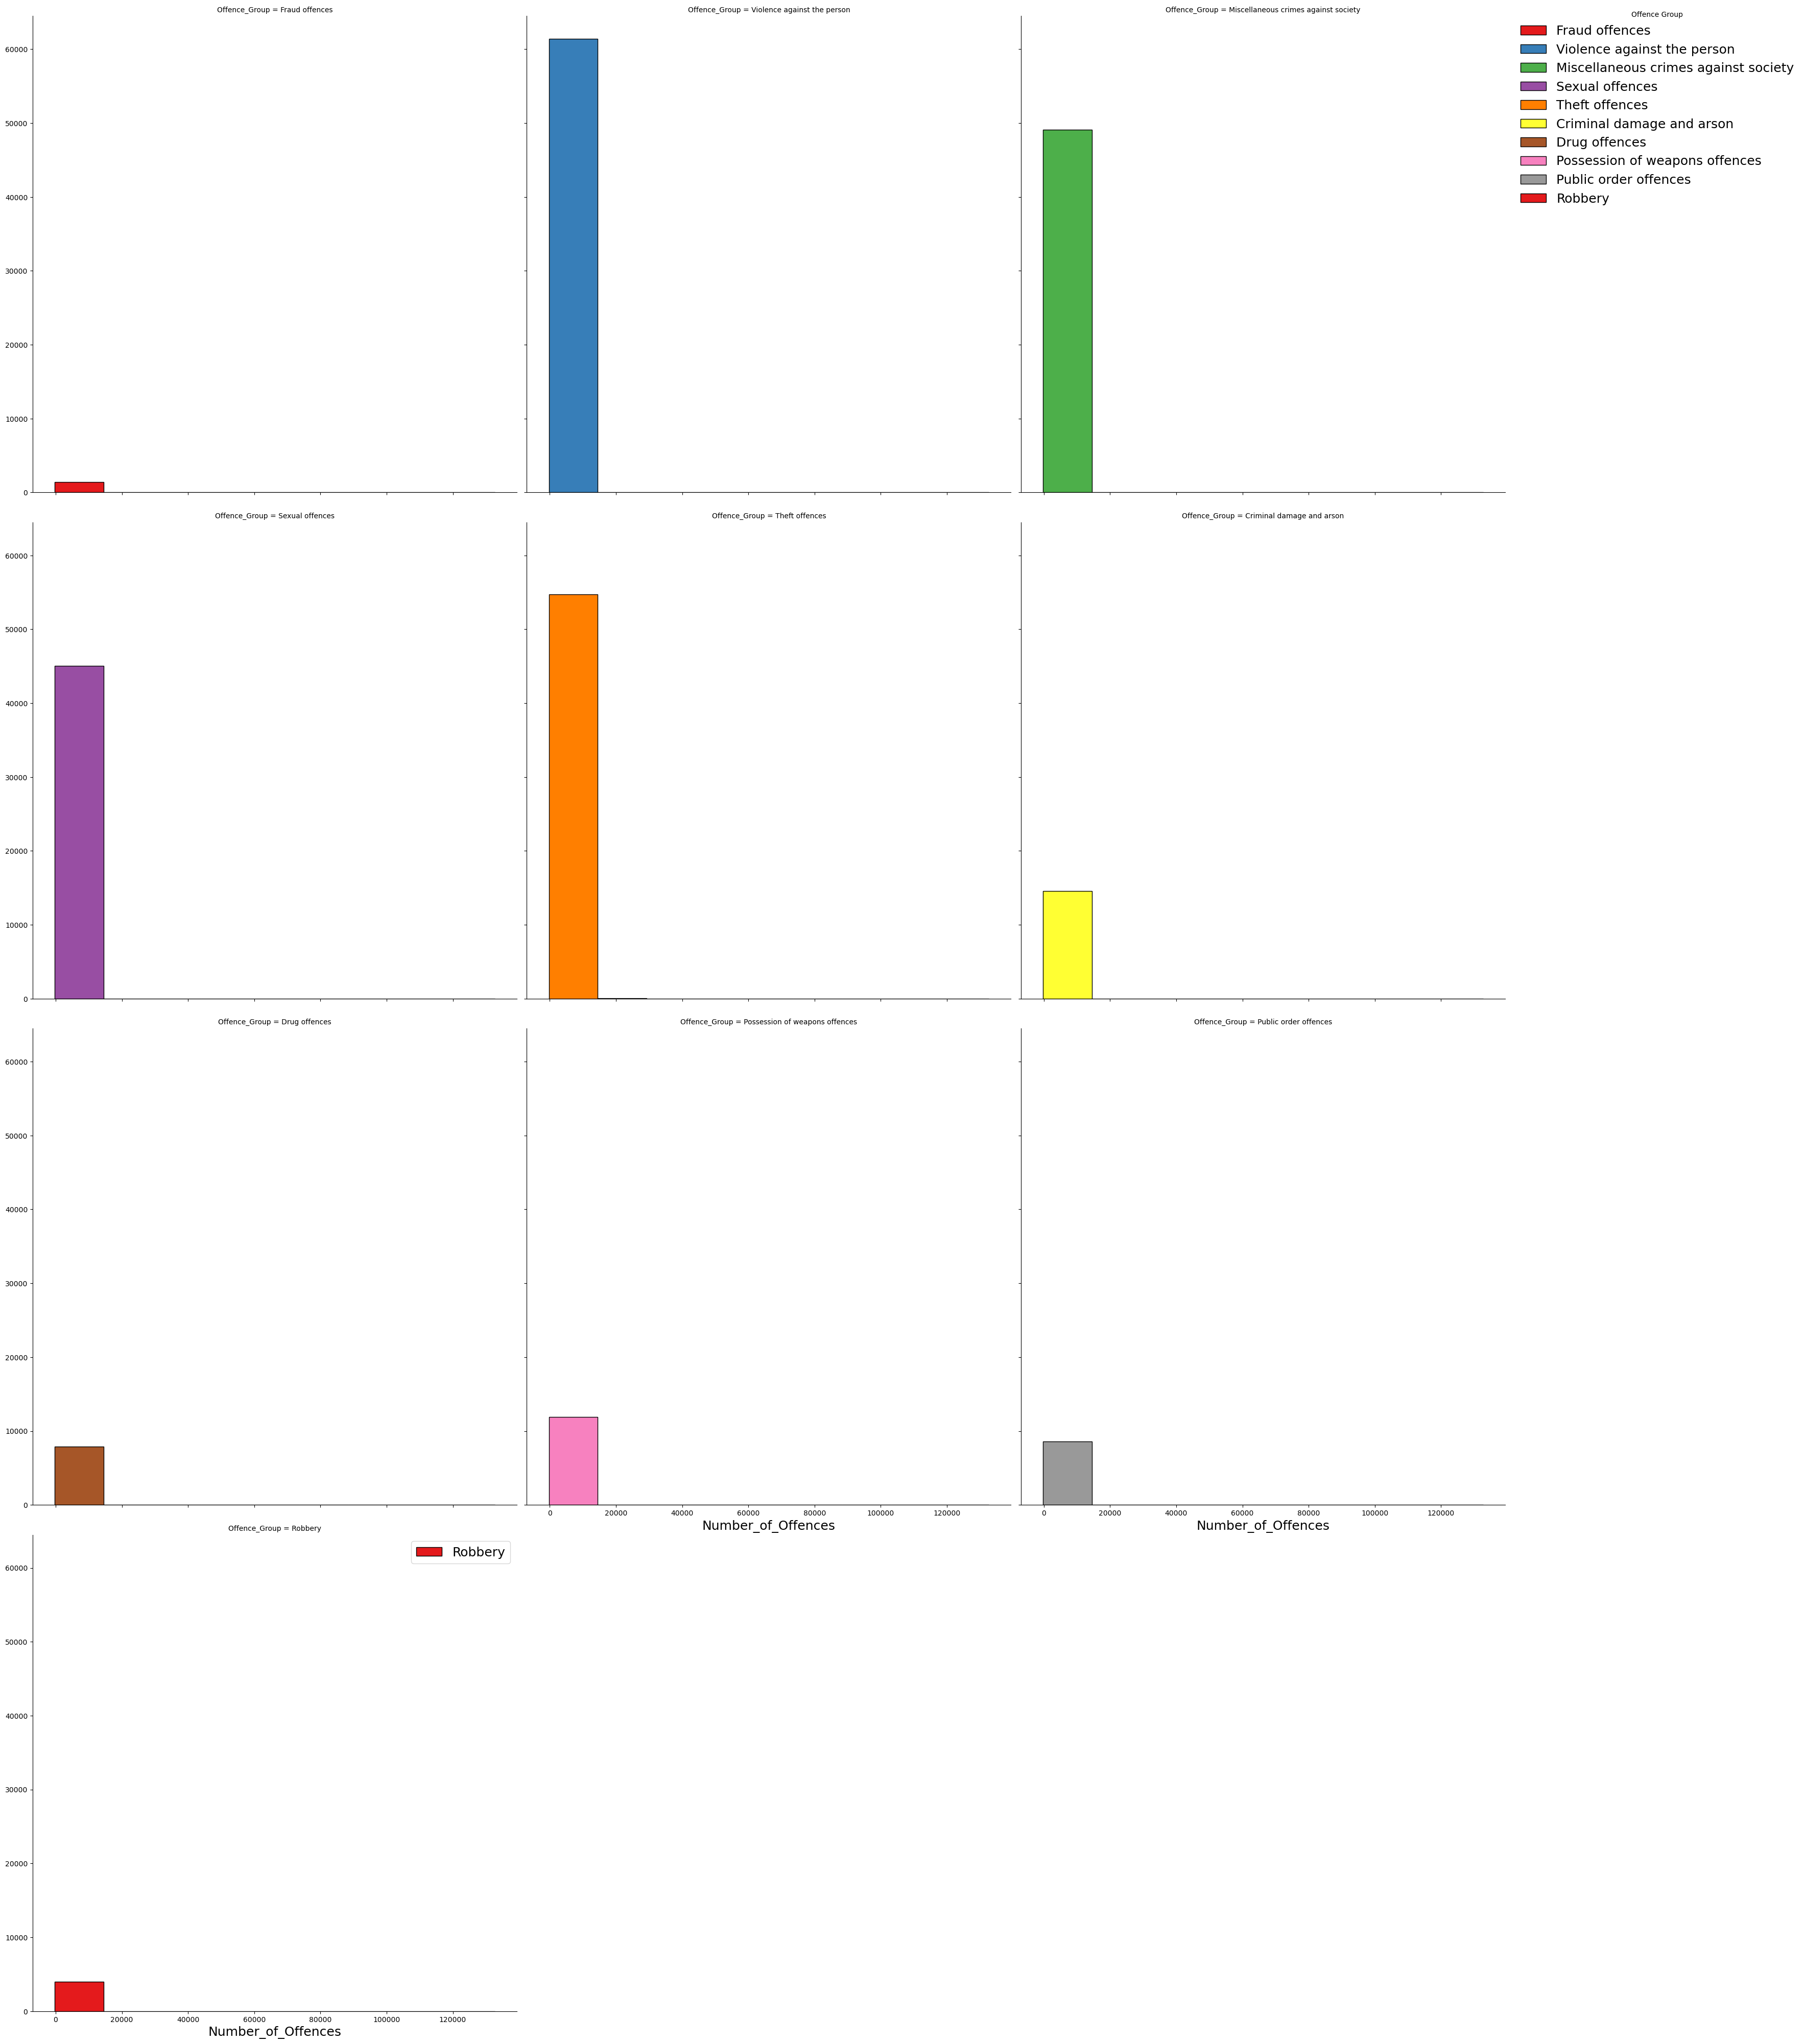

In [17]:
bins = np.linspace(data.Number_of_Offences.min(), data.Number_of_Offences.max(), 10)
g = sns.FacetGrid(data, col='Offence_Group', hue='Offence_Group',palette="Set1", col_wrap=3, height=10)
g.map(plt.hist, 'Number_of_Offences', bins=bins, ec="k")
g.add_legend(title='Offence Group',loc='upper right', fontsize=18)

g.set_axis_labels(fontsize=18)
g.set_titles(fontsize=18)
g.set_xlabels(fontsize=18)
g.set_ylabels(fontsize=18)

plt.legend(fontsize=18)
plt.show()

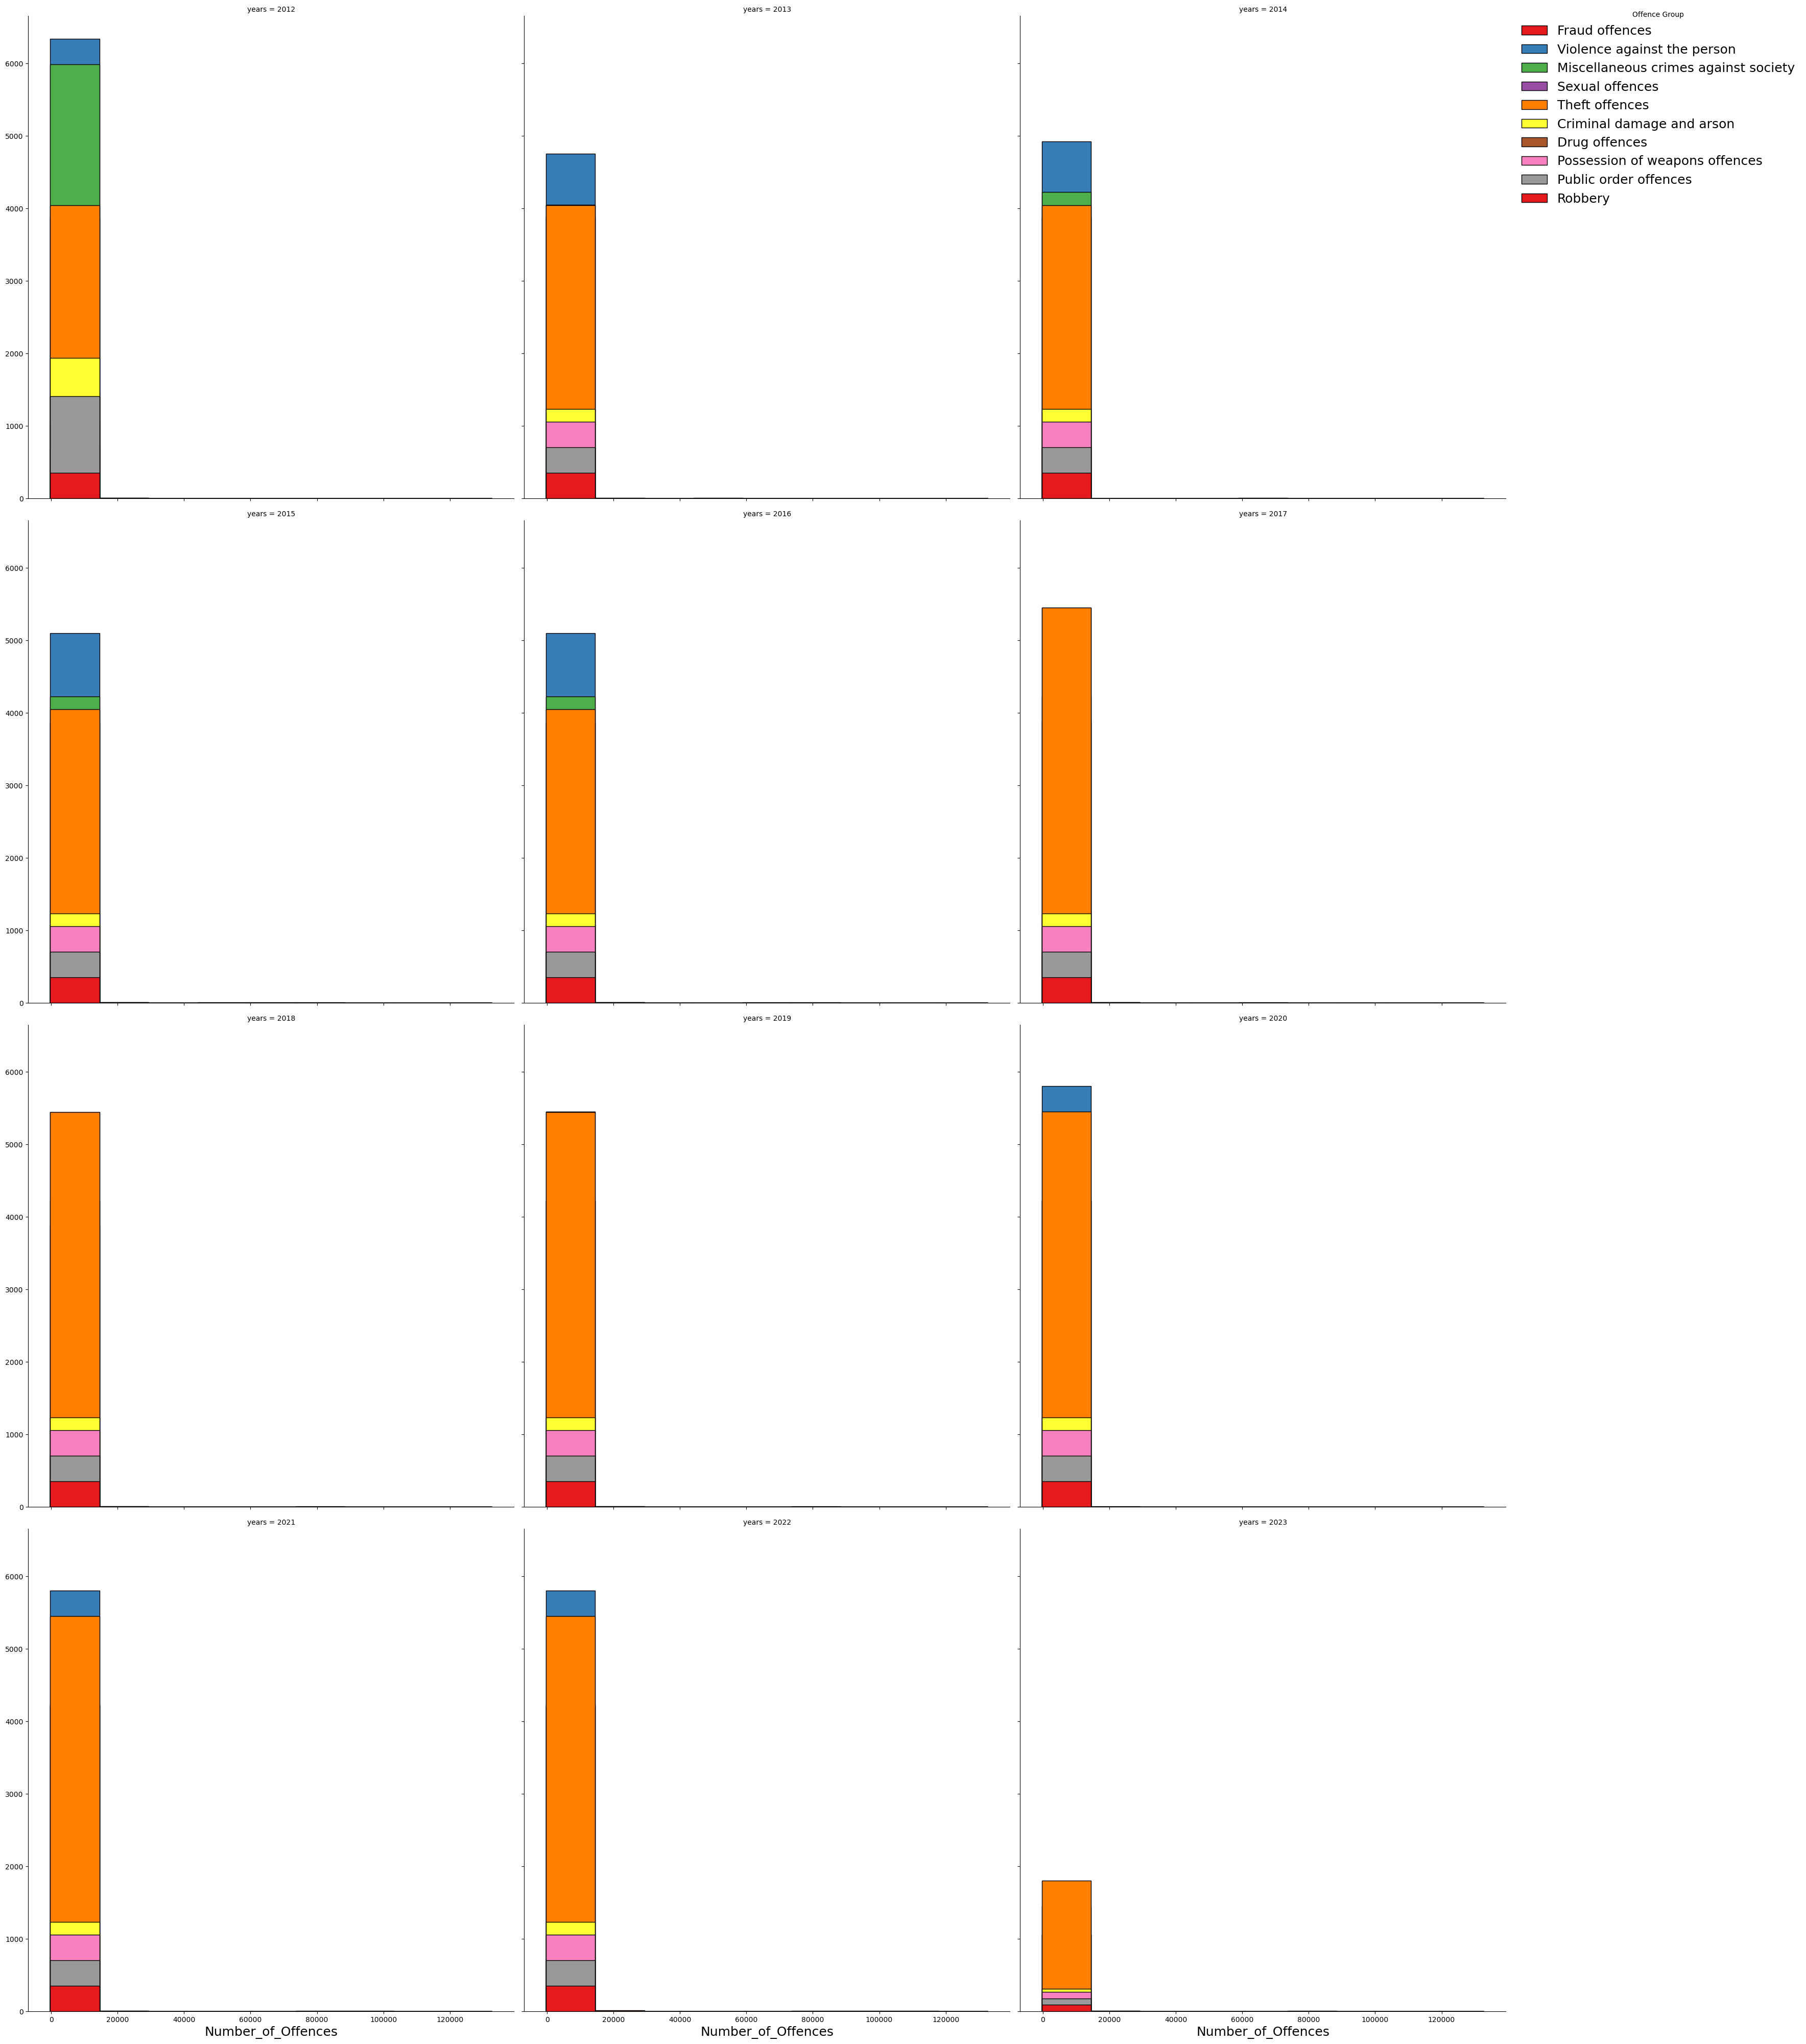

In [18]:
#facetgrid

bins = np.linspace(data.Number_of_Offences.min(), data.Number_of_Offences.max(), 10)
data['years'] = data['years'].astype('category')
g = sns.FacetGrid(data, col='years', hue='Offence_Group',palette="Set1", col_wrap=3, height=10)
g.map(plt.hist, 'Number_of_Offences', bins=bins, ec="k")
g.add_legend(title='Offence Group',loc='upper right', fontsize=18)

g.set_axis_labels(fontsize=18)
g.set_titles(fontsize=18)
g.set_xlabels(fontsize=18)
g.set_ylabels(fontsize=18)

plt.show()

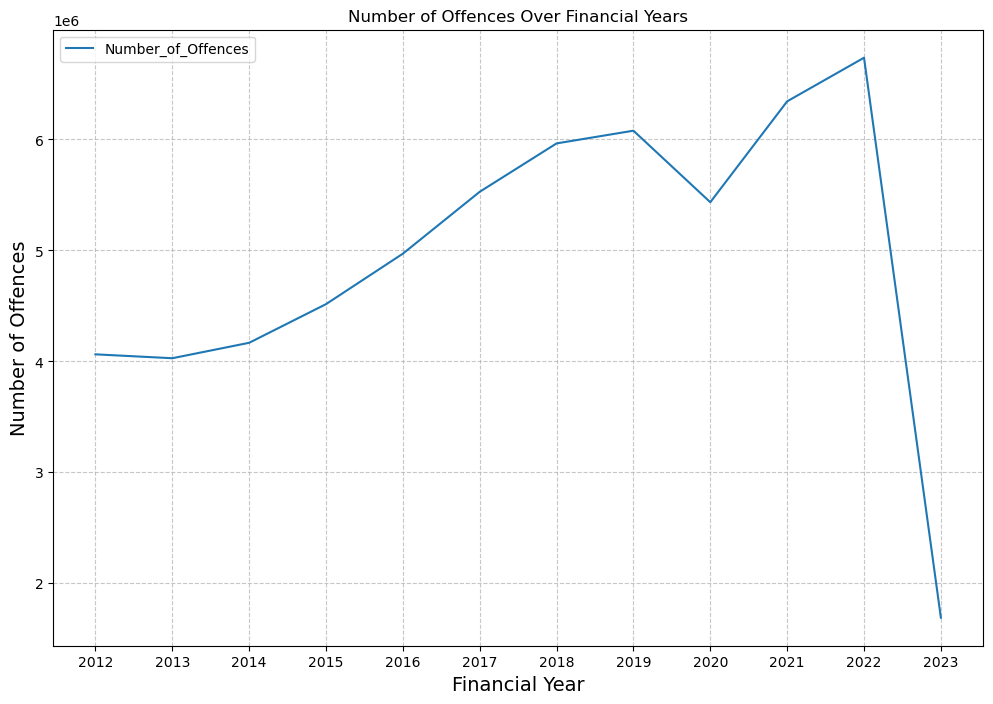

In [19]:
Qrt_off_pivot = data.pivot_table(values='Number_of_Offences', index='years', aggfunc='sum')

plt.figure(figsize=(12, 8))
sns.lineplot(data=Qrt_off_pivot, linestyle='-')
plt.title('Number of Offences Over Financial Years')
plt.xlabel('Financial Year', fontsize=14)
plt.ylabel('Number of Offences', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

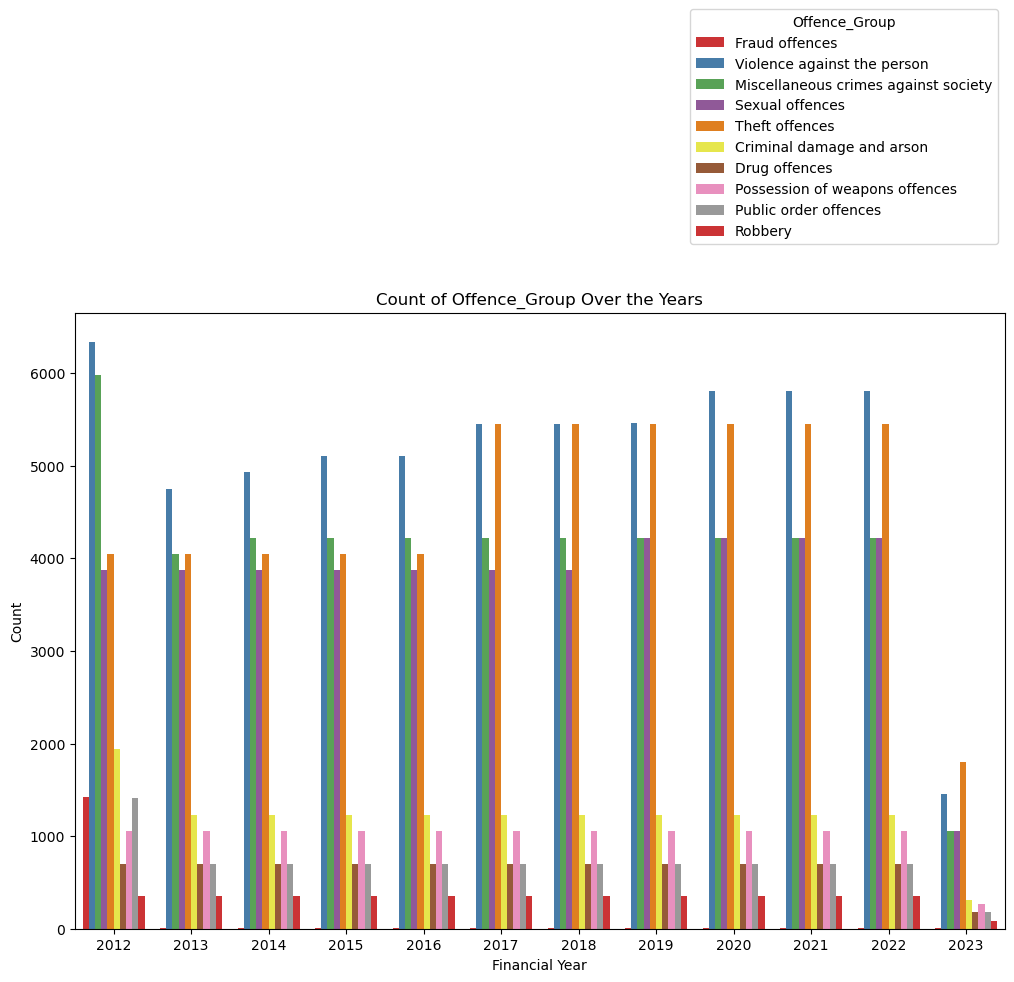

In [ ]:
# Grouping by 'years' and 'Offence_Group' and counting occurrences
plt.figure(figsize=(12, 8))
sns.countplot(x='Financial_Year', hue='Offence_Group', data=data, palette='Set1')
plt.title('Count of Offence_Group Over the Years')
plt.xlabel('Financial Year')
plt.ylabel('Count')
plt.legend(title='Offence_Group', bbox_to_anchor=(1, 1.1), loc='lower right')
plt.show()


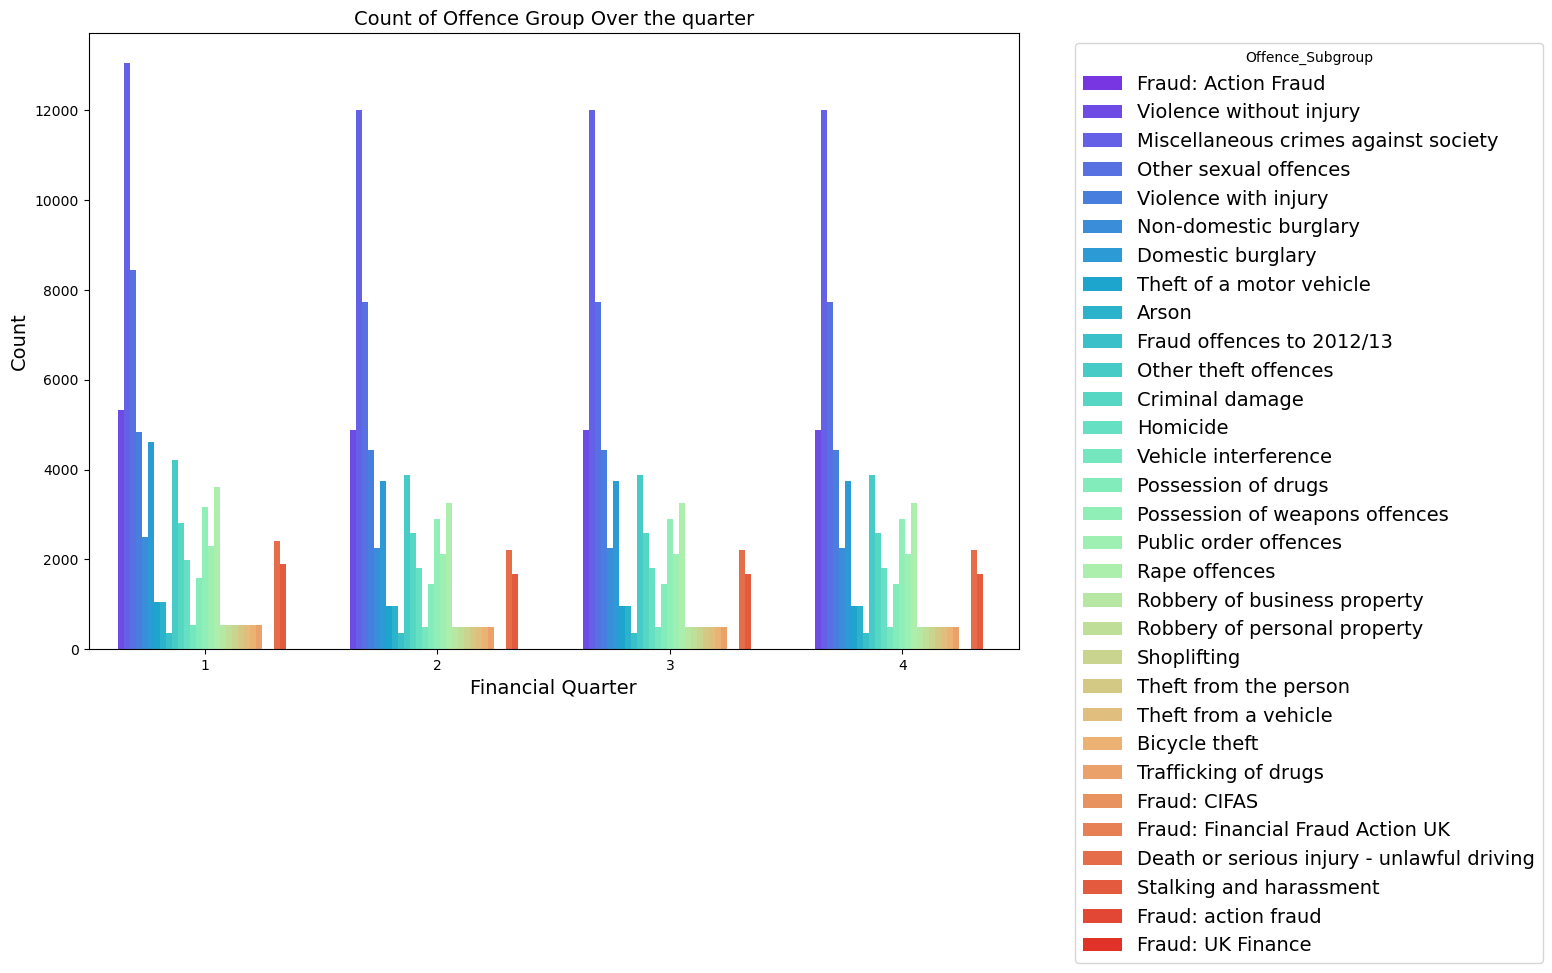

In [ ]:
plt.figure(figsize=(12, 8))
sns.countplot(x='Financial_Quarter', hue='Offence_Subgroup', data=data, palette='rainbow')
plt.title('Count of Offence Group Over the quarter',fontsize=14)
plt.xlabel('Financial Quarter', fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.legend(title='Offence_Subgroup', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
plt.show()


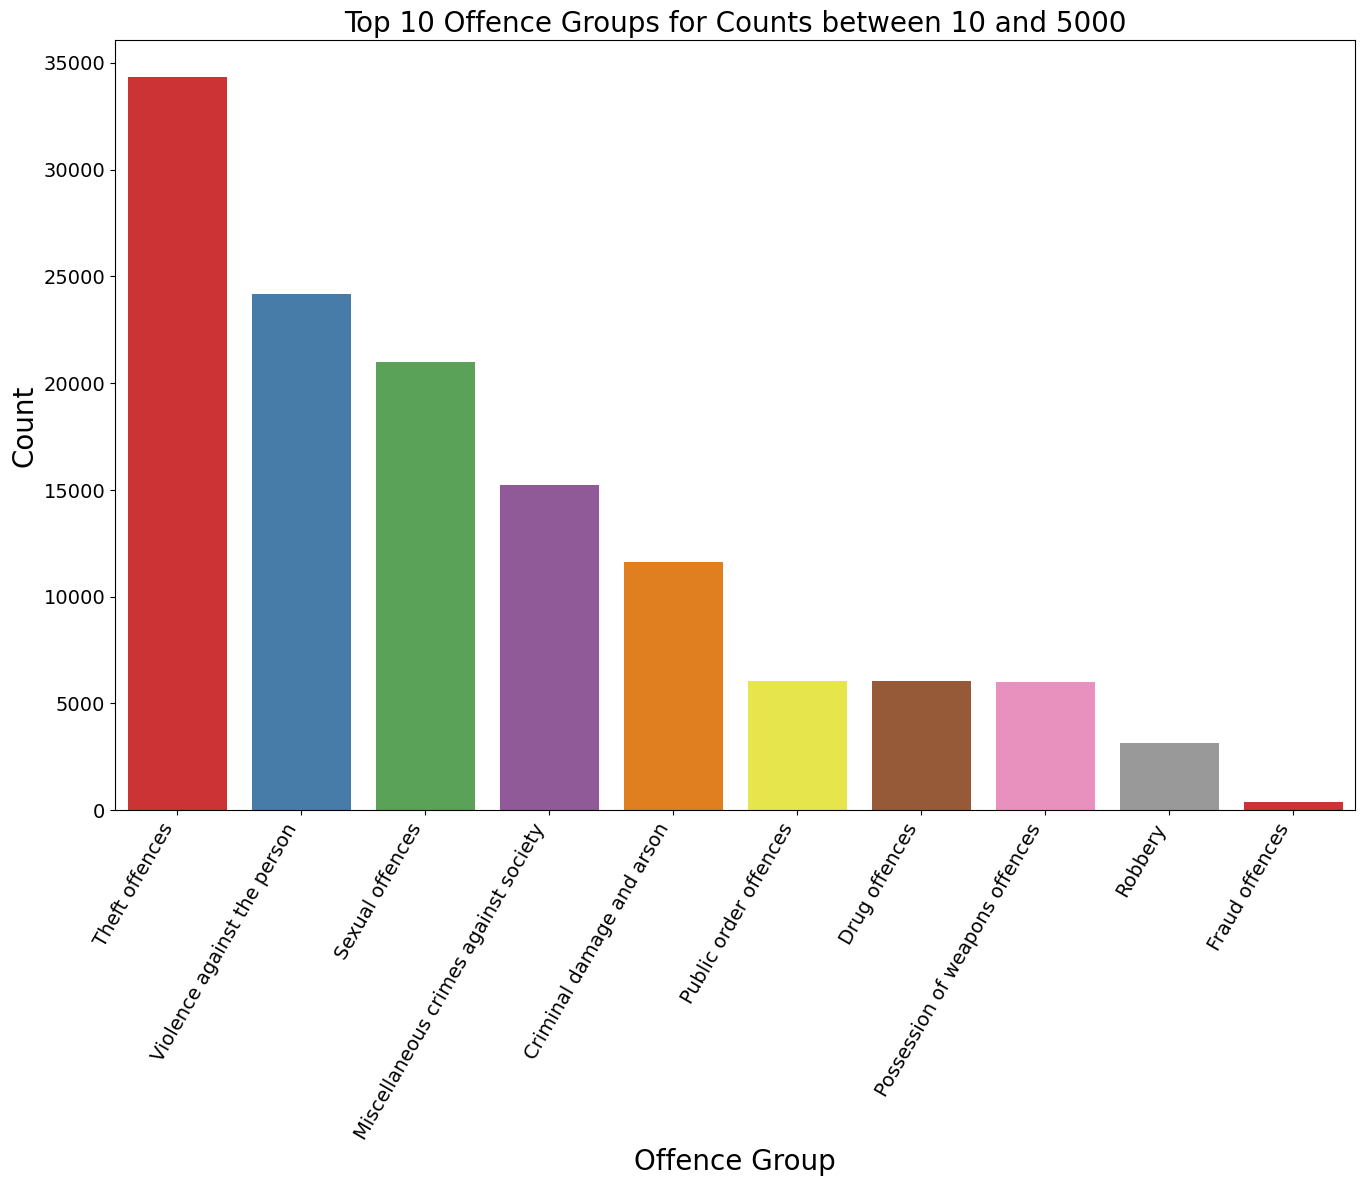

In [ ]:
count_range = (10, 5000)

# Filter the data for the specified range of counts
filtered_data = data[(data['Number_of_Offences'] >= count_range[0]) & (data['Number_of_Offences'] <= count_range[1])]

# a count plot for the top 10 offense groups within the specified count range
plt.figure(figsize=(16, 10))
sns.countplot(x='Offence_Group', data=filtered_data, order=filtered_data['Offence_Group'].value_counts().index[:20], palette='Set1')

plt.title(f'Top 10 Offence Groups for Counts between {count_range[0]} and {count_range[1]}', fontsize=20)
plt.xlabel('Offence Group', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.show()


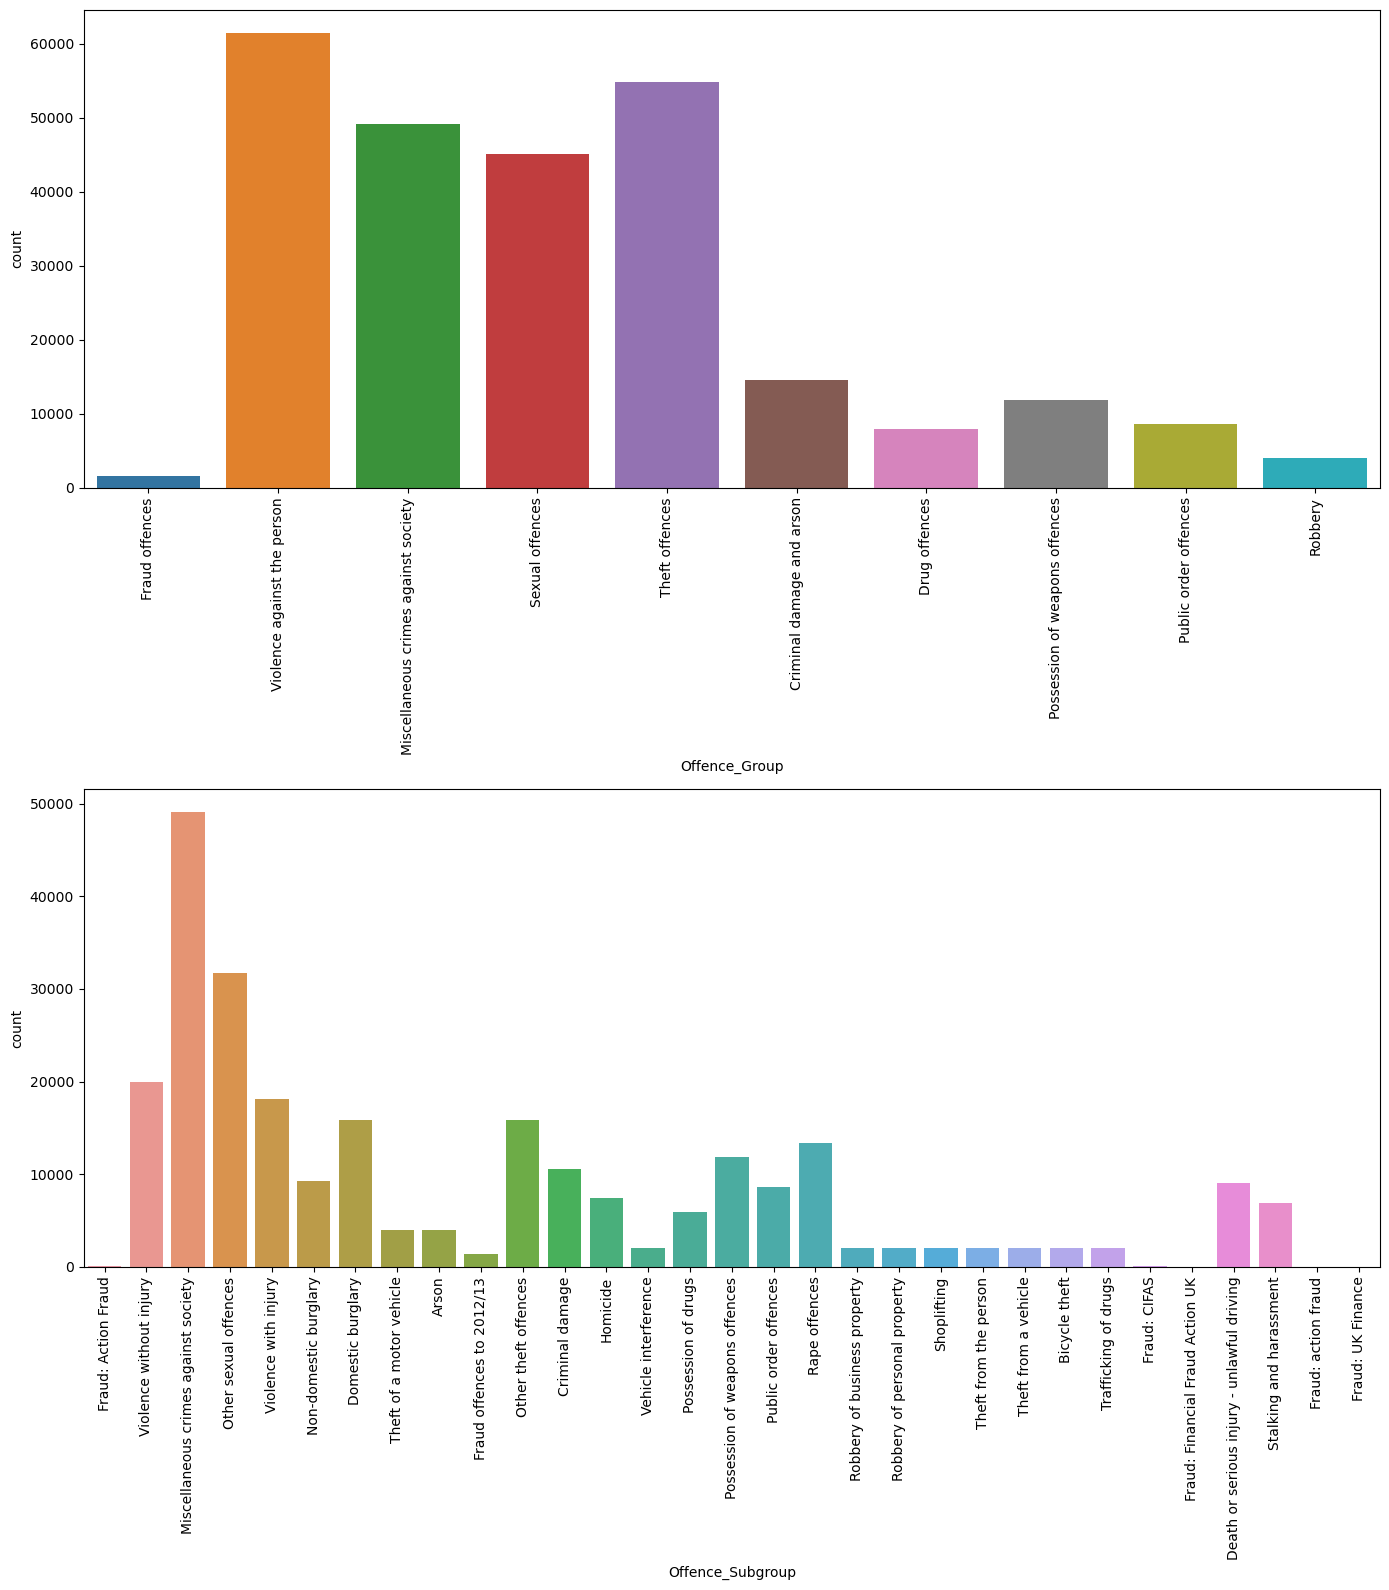

In [ ]:
#list of categorical variables to plot
cat_var = ['Offence_Group','Offence_Subgroup']

fig, axs=plt.subplots(len(cat_var),1,figsize=(14,8 *len(cat_var)))
axs =axs.flatten()
#create a countplot for each categorical variable
for i, var in enumerate(cat_var):
    sns.countplot(x=var, data=data, ax=axs[i])
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
fig.tight_layout()
plt.show()

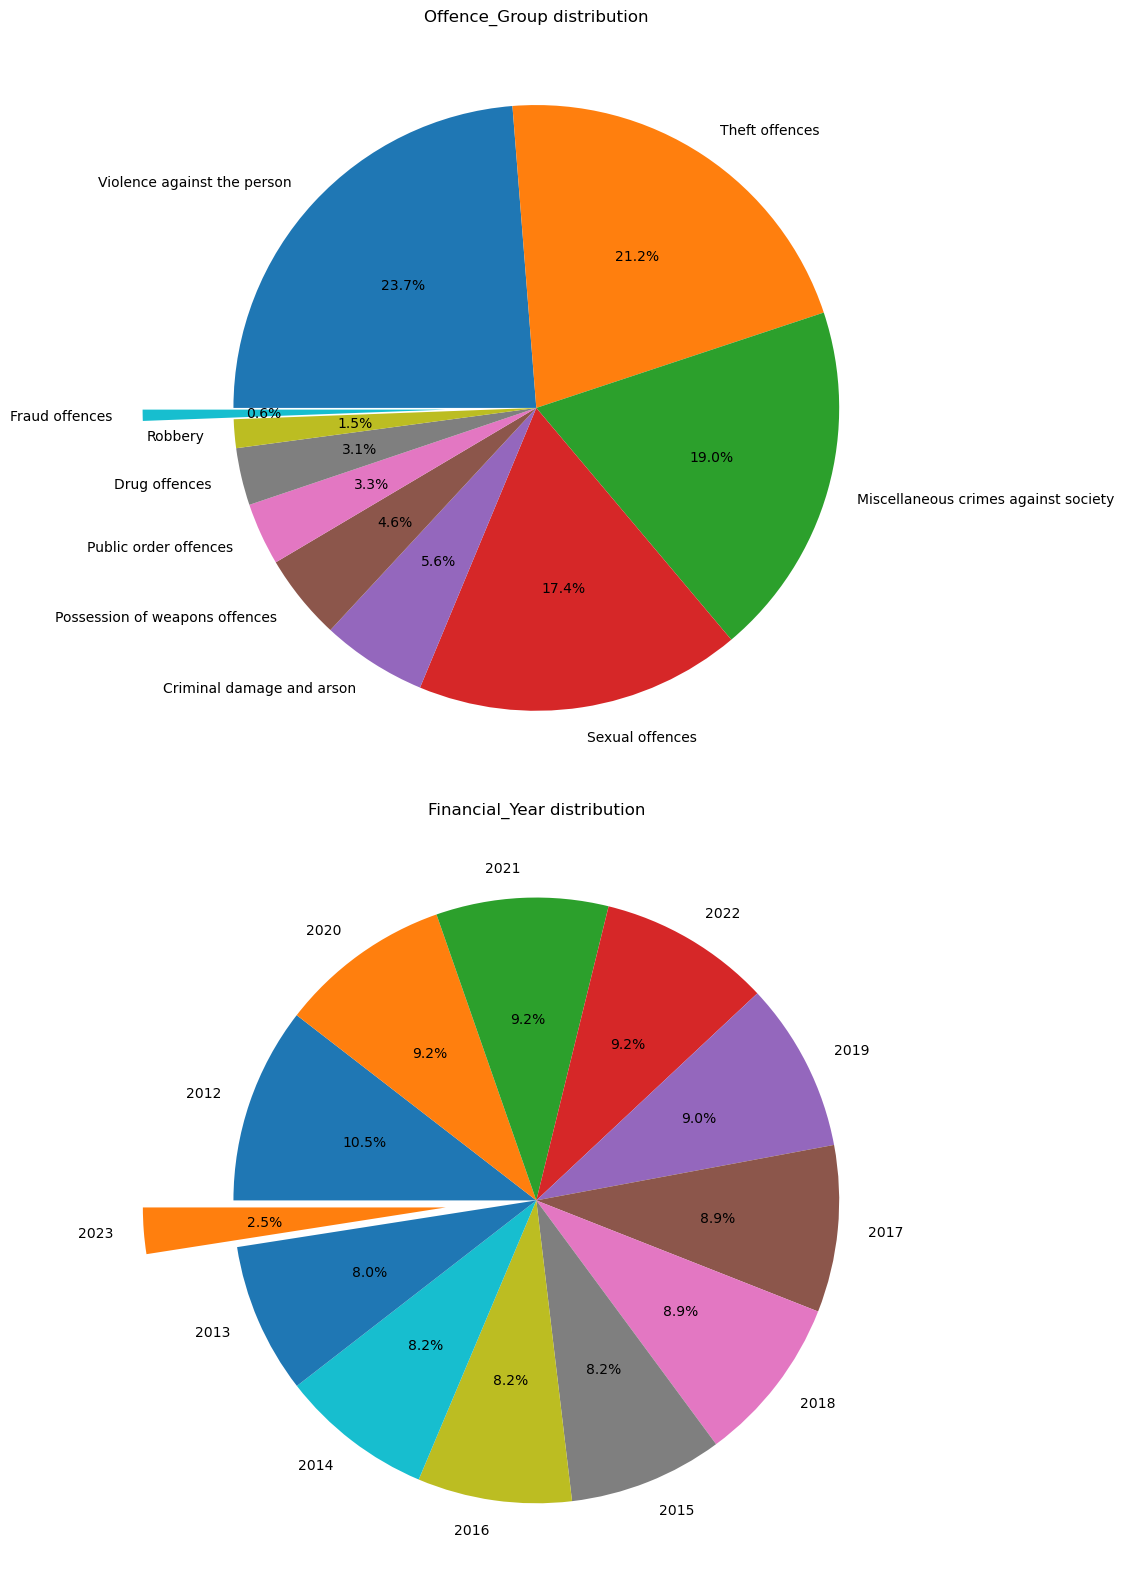

In [ ]:
cat_var = ['Offence_Group','Financial_Year']

fig, axs=plt.subplots(len(cat_var),1,figsize=(14,8 *len(cat_var)))
axs =axs.flatten()
#create a pie chart for each categorical variable
for i, var in enumerate(cat_var):
    if i < len(axs):
        cat_count=data[var].value_counts()
        explode_values = [0.3 if count == cat_count.nsmallest(1).values[0] else 0 for count in cat_count]
        axs.flat[i].pie(cat_count,labels=cat_count.index,autopct='%1.1f%%',startangle=180, counterclock=False, explode=explode_values)
        axs.flat[i].set_title(f'{var} distribution')
fig.tight_layout()
plt.show()

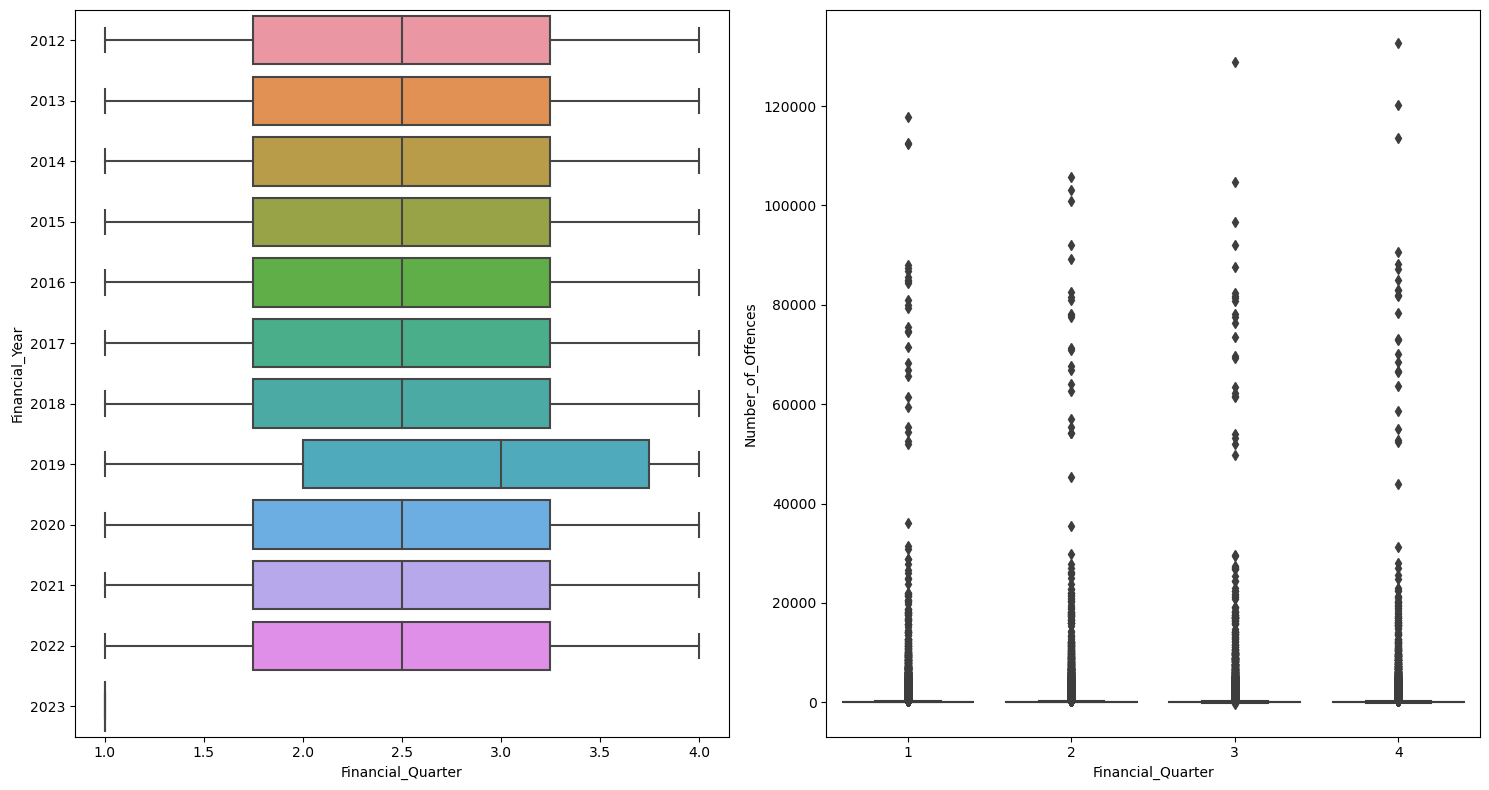

In [ ]:
num_var =['Financial_Year','Number_of_Offences']

fig, axs=plt.subplots(1,2,figsize=(15,8))
axs=axs.flatten()

for i, var in enumerate(num_var):
    sns.boxplot(y=var, x='Financial_Quarter', data=data, ax=axs[i])

fig.tight_layout()
plt.show()

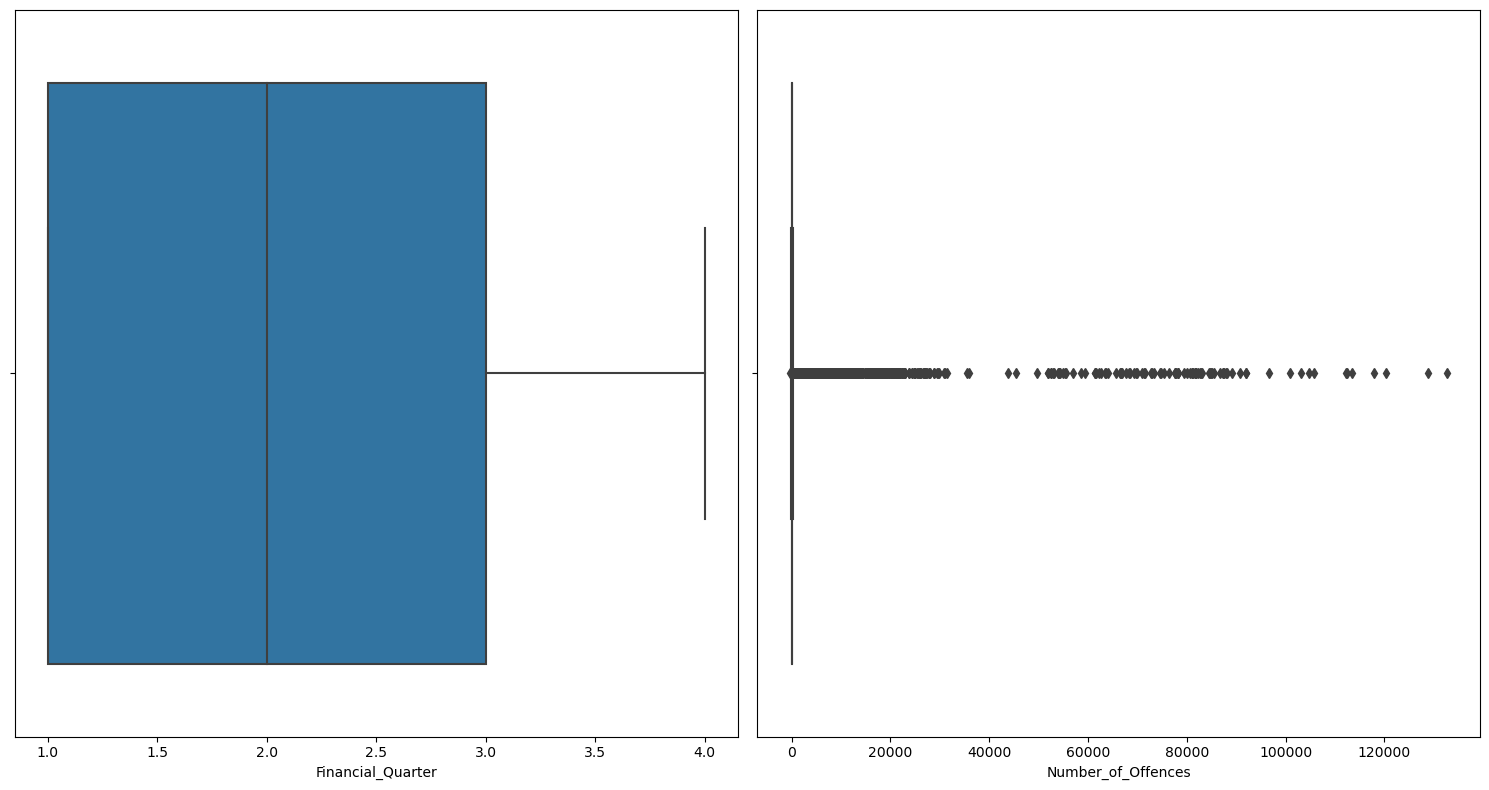

In [ ]:
num_var =['Financial_Quarter','Number_of_Offences']

fig, axs=plt.subplots(1,2,figsize=(15,8))
axs=axs.flatten()

for i, var in enumerate(num_var):
    sns.boxplot(x=var, data=data, ax=axs[i])

fig.tight_layout()
plt.show()

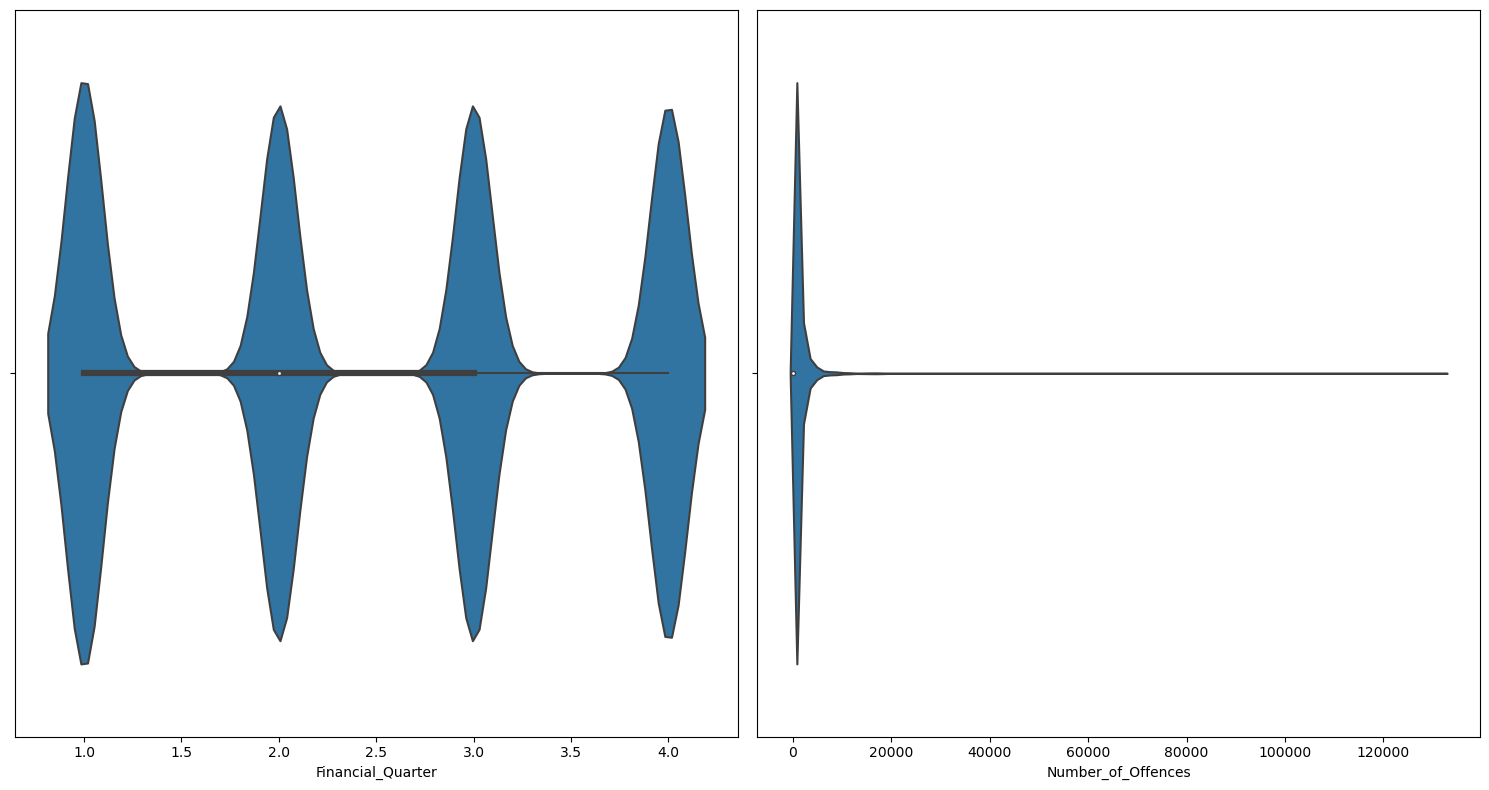

In [ ]:
num_var =['Financial_Quarter','Number_of_Offences']

fig, axs=plt.subplots(1,2,figsize=(15,8))
axs=axs.flatten()

for i, var in enumerate(num_var):
    sns.violinplot(x=var, data=data, ax=axs[i])

fig.tight_layout()
plt.show()

**SQL Setion**

In [16]:
import pymysql
import sqlalchemy
import sqlite3
import sql

In [ ]:
con = sqlite3.connect("Recoreded_crime.db")
cur = con.cursor()


In [ ]:
%reload_ext sql
%sql sqlite:///Recoreded_crime.db

In [ ]:
#%sql --persist data #uncomment

In [ ]:
%sql select name from sqlite_master where type='table';

 * sqlite:///Recoreded_crime.db
Done.


name
data


In [ ]:
%sql select * from data \
limit 5;

 * sqlite:///Recoreded_crime.db
Done.


index,Financial_Year,Financial_Quarter,Force_Name,Offence_Description,Offence_Group,Offence_Subgroup,Offence_Code,Number_of_Offences
0,2012,1,Action Fraud,Fraud offences recorded by Action Fraud,Fraud offences,Fraud: Action Fraud,AF,20323
1,2012,1,Avon and Somerset,Abandoning child under two years (outcomes only),Violence against the person,Violence without injury,12,0
2,2012,1,Avon and Somerset,Absconding from lawful custody,Miscellaneous crimes against society,Miscellaneous crimes against society,80,1
3,2012,1,Avon and Somerset,Abuse of children through prostitution and pornography,Sexual offences,Other sexual offences,71,0
4,2012,1,Avon and Somerset,Abuse of position of trust of a sexual nature,Sexual offences,Other sexual offences,73,3


In [ ]:
%sql select Financial_Year, Force_Name, Offence_Group, Number_of_Offences from data \
where Number_of_Offences > 15 \
order by Force_Name desc \
limit 5;

 * sqlite:///Recoreded_crime.db
Done.


Financial_Year,Force_Name,Offence_Group,Number_of_Offences
2012,Wiltshire,Criminal damage and arson,53
2012,Wiltshire,Violence against the person,867
2012,Wiltshire,Violence against the person,22
2012,Wiltshire,Violence against the person,626
2012,Wiltshire,Violence against the person,30


In [ ]:
%sql select Offence_Code,Force_Name,Offence_Subgroup,Offence_Group from data\
where Number_of_Offences = 45\
limit 5;

 * sqlite:///Recoreded_crime.db
Done.


Offence_Code,Force_Name,Offence_Subgroup,Offence_Group
37.2,Avon and Somerset,Theft of a motor vehicle,Theft offences
5D,Cleveland,Violence with injury,Violence against the person
61,Devon and Cornwall,Miscellaneous crimes against society,Miscellaneous crimes against society
56B,Dorset,Arson,Criminal damage and arson
104,Durham,Violence without injury,Violence against the person


In [ ]:
%sql UPDATE data \
SET Financial_Year = FORMAT(Financial_Year, 'YYYY');
%sql select * from data \
limit 5;

 * sqlite:///Recoreded_crime.db
258905 rows affected.
 * sqlite:///Recoreded_crime.db
Done.


index,Financial_Year,Financial_Quarter,Force_Name,Offence_Description,Offence_Group,Offence_Subgroup,Offence_Code,Number_of_Offences
0,2012,1,Action Fraud,Fraud offences recorded by Action Fraud,Fraud offences,Fraud: Action Fraud,AF,20323
1,2012,1,Avon and Somerset,Abandoning child under two years (outcomes only),Violence against the person,Violence without injury,12,0
2,2012,1,Avon and Somerset,Absconding from lawful custody,Miscellaneous crimes against society,Miscellaneous crimes against society,80,1
3,2012,1,Avon and Somerset,Abuse of children through prostitution and pornography,Sexual offences,Other sexual offences,71,0
4,2012,1,Avon and Somerset,Abuse of position of trust of a sexual nature,Sexual offences,Other sexual offences,73,3


In [ ]:
%sql select Offence_Group, Number_of_Offences, Financial_Year from data\
where Offence_Group in ('Miscellaneous crimes against society','Fraud offences','Sexual offences','Violence against the person') and Number_of_Offences > 5 and Financial_Year in (2015,2022)\
limit 5;

 * sqlite:///Recoreded_crime.db
Done.


Offence_Group,Number_of_Offences,Financial_Year
Violence against the person,2461,2015
Violence against the person,153,2015
Violence against the person,2531,2015
Violence against the person,124,2015
Violence against the person,8,2015


In [ ]:
#Converting query result to dataframes
off_group = %sql select Offence_Group, Number_of_Offences, Financial_Year from data\
where Offence_Group in ('Miscellaneous crimes against society','Fraud offences','Sexual offences','Violence against the person') and Number_of_Offences > 5 and Financial_Year in (2015,2022)\
order by Offence_Group desc;

 * sqlite:///Recoreded_crime.db
Done.


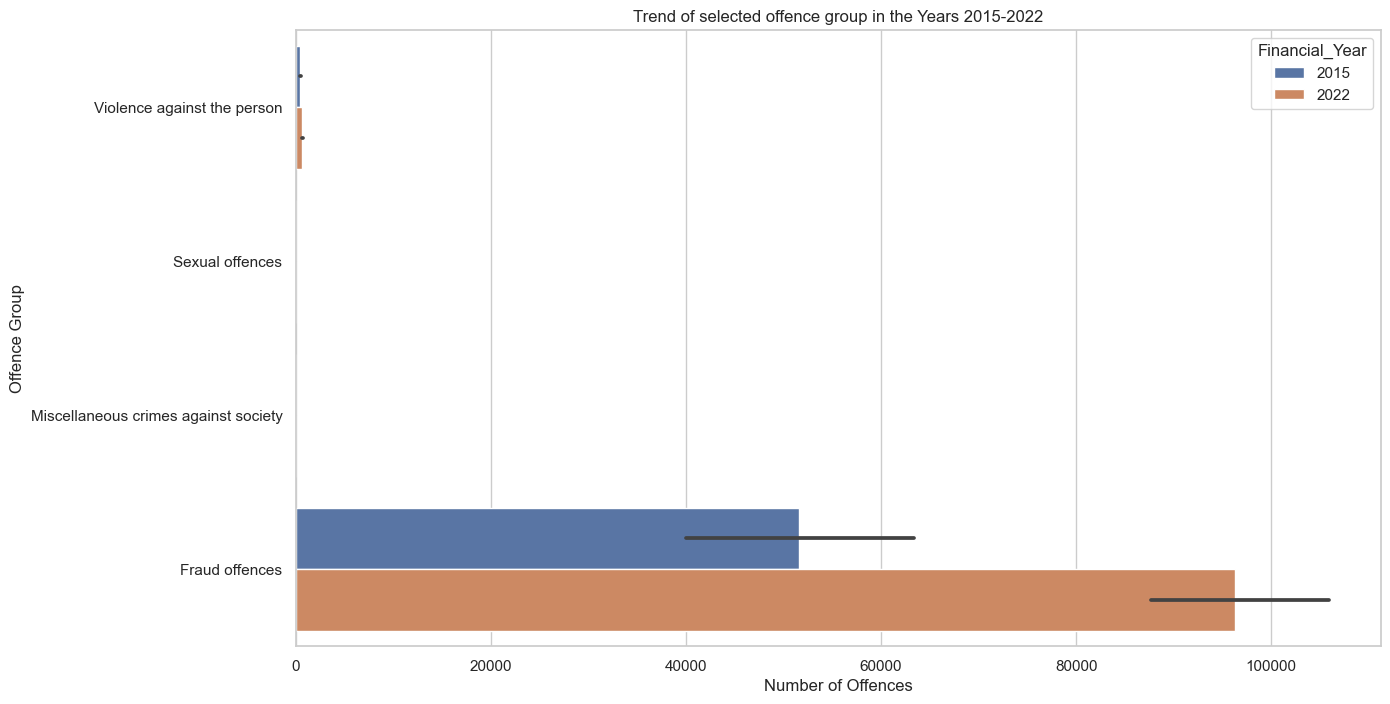

In [ ]:
#creating a plot from the query instance in python
off_group_data = off_group.DataFrame()
plot = sns.set_theme(style='whitegrid')
plt.figure(figsize=(14, 8))
sns.barplot(x='Number_of_Offences', y='Offence_Group', hue='Financial_Year', data=off_group_data)
plt.title('Trend of selected offence group in the Years 2015-2022')
plt.xlabel('Number of Offences')
plt.ylabel('Offence Group')
plt.show()

In [ ]:
# %sql alter table data \
# drop column years;

In [ ]:
con.close() #do this to release memory usage


**Data Preprocessing**

In [ ]:
#create another copy for ML
ml_data = data

In [ ]:
del data #do this to release memory usage

In [ ]:
ml_data.head()

,Financial_Year,Financial_Quarter,Force_Name,Offence_Description,Offence_Group,Offence_Subgroup,Offence_Code,Number_of_Offences,years
0,2012,1,Action Fraud,Fraud offences recorded by Action Fraud,Fraud offences,Fraud: Action Fraud,AF,20323,2012
1,2012,1,Avon and Somerset,Abandoning child under two years (outcomes only),Violence against the person,Violence without injury,12,0,2012
2,2012,1,Avon and Somerset,Absconding from lawful custody,Miscellaneous crimes against society,Miscellaneous crimes against society,80,1,2012
3,2012,1,Avon and Somerset,Abuse of children through prostitution and por...,Sexual offences,Other sexual offences,71,0,2012
4,2012,1,Avon and Somerset,Abuse of position of trust of a sexual nature,Sexual offences,Other sexual offences,73,3,2012


In [ ]:
check_missing = ml_data.isnull().sum() *100/ml_data.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

Series([], dtype: float64)

In [ ]:
ml_data.drop('years',inplace=True, axis=1)

In [ ]:
ml_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258905 entries, 0 to 258904
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Financial_Year       258905 non-null  object
 1   Financial_Quarter    258905 non-null  int64 
 2   Force_Name           258905 non-null  object
 3   Offence_Description  258905 non-null  object
 4   Offence_Group        258905 non-null  object
 5   Offence_Subgroup     258905 non-null  object
 6   Offence_Code         258905 non-null  object
 7   Number_of_Offences   258905 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 15.8+ MB


In [ ]:
ml_data.isnull().sum()

Financial_Year         0
Financial_Quarter      0
Force_Name             0
Offence_Description    0
Offence_Group          0
Offence_Subgroup       0
Offence_Code           0
Number_of_Offences     0
dtype: int64

In [ ]:
ml_data['Offence_Group'].value_counts()

Violence against the person             61474
Theft offences                          54780
Miscellaneous crimes against society    49104
Sexual offences                         45056
Criminal damage and arson               14564
Possession of weapons offences          11880
Public order offences                    8624
Drug offences                            7920
Robbery                                  3960
Fraud offences                           1543
Name: Offence_Group, dtype: int64

In [ ]:
for col in ml_data.select_dtypes(include=['object']).columns:
    print(f"{col}:{ml_data[col].unique()}")


Financial_Year:['2012' '2013' '2014' '2015' '2016' '2017' '2018' '2019' '2020' '2021'
 '2022' '2023']
Force_Name:['Action Fraud' 'Avon and Somerset' 'Bedfordshire'
 'British Transport Police' 'Cambridgeshire' 'Cheshire' 'CIFAS'
 'Cleveland' 'Cumbria' 'Derbyshire' 'Devon and Cornwall' 'Dorset' 'Durham'
 'Dyfed-Powys' 'Essex' 'Financial Fraud Action UK' 'Gloucestershire'
 'Greater Manchester' 'Gwent' 'Hampshire' 'Hertfordshire' 'Humberside'
 'Kent' 'Lancashire' 'Leicestershire' 'Lincolnshire' 'London, City of'
 'Merseyside' 'Metropolitan Police' 'Norfolk' 'North Wales'
 'North Yorkshire' 'Northamptonshire' 'Northumbria' 'Nottinghamshire'
 'South Wales' 'South Yorkshire' 'Staffordshire' 'Suffolk' 'Surrey'
 'Sussex' 'Thames Valley' 'Warwickshire' 'West Mercia' 'West Midlands'
 'West Yorkshire' 'Wiltshire' 'Cifas' 'UK Finance']
Offence_Description:['Fraud offences recorded by Action Fraud'
 'Abandoning child under two years (outcomes only)'
 'Absconding from lawful custody'
 'Abuse of child

In [ ]:
for col in ml_data.select_dtypes(include=['object']).columns:
    print(f"{col}:{ml_data[col].nunique()}")

Financial_Year:12
Force_Name:49
Offence_Description:201
Offence_Group:10
Offence_Subgroup:31
Offence_Code:190


In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
for col in ml_data.select_dtypes(include=['object']).columns:
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(ml_data[col].unique())
    ml_data[col] = label_encoder.transform(ml_data[col])
    print(f"{col}:{ml_data[col].unique()}")

Financial_Year:[ 0  1  2  3  4  5  6  7  8  9 10 11]
Force_Name:[ 0  1  2  3  5  6  4  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 44 45 46 47 48  7
 43]
Offence_Description:[ 90   0   1   2   4   5   6  11  13  15  16  17  18  19  21  22  23  28
  30  34  36  39  40  41  42  43  46  48  50  51  52  53  54  57  58  59
  60  61  64  65  66  67  68  69  70  71  72  76  78  79  80  81  82  83
  84  85  86  87  88  89  94  95  96  97  98  99 100 101 103 104 105 106
 107 108 109 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 158 159 160 161 162 163 166 167 168 169
 170 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 200  91  92   3  12  14  29  31
  35  47  49  55  56  63  77 102 110 112 114 179 199 113   7   8  20  25
  26  27  44  45  73 111  93 156 15

In [ ]:
ml_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258905 entries, 0 to 258904
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   Financial_Year       258905 non-null  int32
 1   Financial_Quarter    258905 non-null  int64
 2   Force_Name           258905 non-null  int32
 3   Offence_Description  258905 non-null  int32
 4   Offence_Group        258905 non-null  int32
 5   Offence_Subgroup     258905 non-null  int32
 6   Offence_Code         258905 non-null  int32
 7   Number_of_Offences   258905 non-null  int64
dtypes: int32(6), int64(2)
memory usage: 9.9 MB


<Axes: >

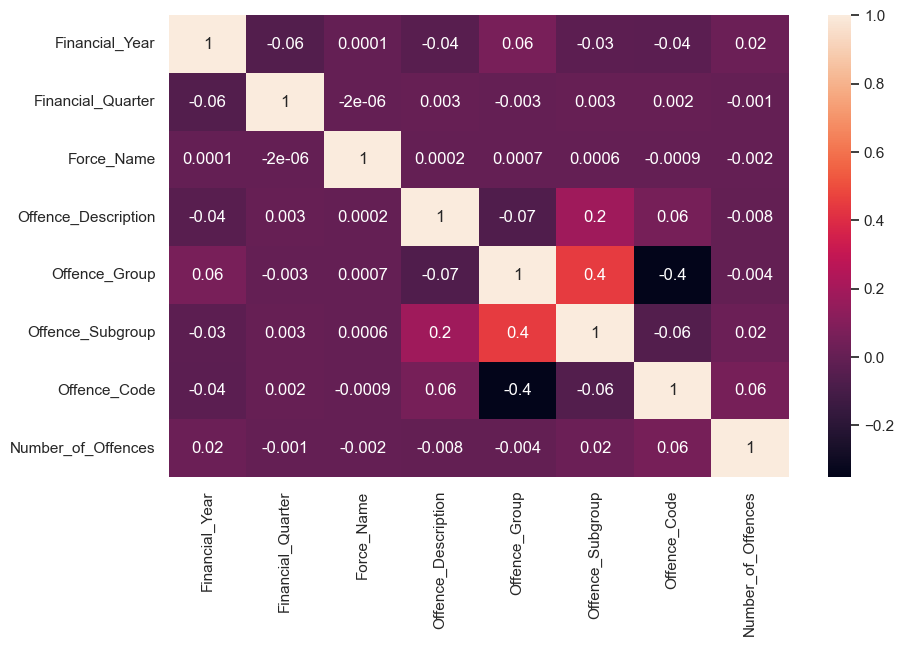

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(ml_data.corr(), fmt='.1g', annot=True)

In [ ]:
#ml_data = ml_data.astype(float)

In [ ]:
features = ml_data.drop(columns='Offence_Group', axis=1)
y = ml_data['Offence_Group']

In [ ]:
ml_data['Offence_Group'][0:5]

0    2
1    9
2    3
3    7
4    7
Name: Offence_Group, dtype: int32

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, y, test_size = 0.3, random_state=42)
print ('Train set:', x_train.shape,  y_train.shape)
print ('Test set:', x_test.shape,  y_test.shape)

Train set: (181233, 7) (181233,)
Test set: (77672, 7) (77672,)


In [ ]:
features = preprocessing.StandardScaler().fit(features).transform(features)
features[0:5]

array([[-1.56679191, -1.29655704, -1.85687331, -0.27730643, -1.15775428,
         1.78103799, 11.65249646],
       [-1.56679191, -1.29655704, -1.78298042, -1.83707339,  1.76032486,
        -1.3840608 , -0.1333259 ],
       [-1.56679191, -1.29655704, -1.78298042, -1.81974264, -0.4282345 ,
         1.03523885, -0.13274597],
       [-1.56679191, -1.29655704, -1.78298042, -1.8024119 , -0.18506123,
         0.90790729, -0.1333259 ],
       [-1.56679191, -1.29655704, -1.78298042, -1.76775041, -0.18506123,
         0.94428774, -0.13158612]])

**Multiple Linear Regression**

In [ ]:
from sklearn.linear_model import LinearRegression

LR_model = LinearRegression().fit(x_train, y_train)
LR_model

LinearRegression()

In [ ]:
prediction = LR_model.predict(x_test)
prediction[0:5]

array([6.95106859, 6.69439111, 7.28615126, 4.5234412 , 4.0862543 ])

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

LinearRegression_MAE = mean_absolute_error(y_test, prediction)
LinearRegression_MSE = mean_squared_error(y_test, prediction)
LinearRegression_R2 = r2_score(y_test, prediction)


In [ ]:
list_mae = [LinearRegression_MAE]
list_mse = [LinearRegression_MSE]
list_r2 = [LinearRegression_R2]


Report = pd.DataFrame(list_r2, index=['Multiple Linear Regression'])
Report.columns = ['R-squared (R2)']
Report.insert(loc=1, column='Mean Absolute Error (MAE)', value=list_mae)
Report.insert(loc=2, column='Mean Squared Error (MSE)', value=list_mse)
Report.columns.name = 'Algorithm'
print(Report)

Algorithm                   R-squared (R2)  Mean Absolute Error (MAE)  \
Multiple Linear Regression        0.328858                   1.942692   

Algorithm                   Mean Squared Error (MSE)  
Multiple Linear Regression                  5.353687  


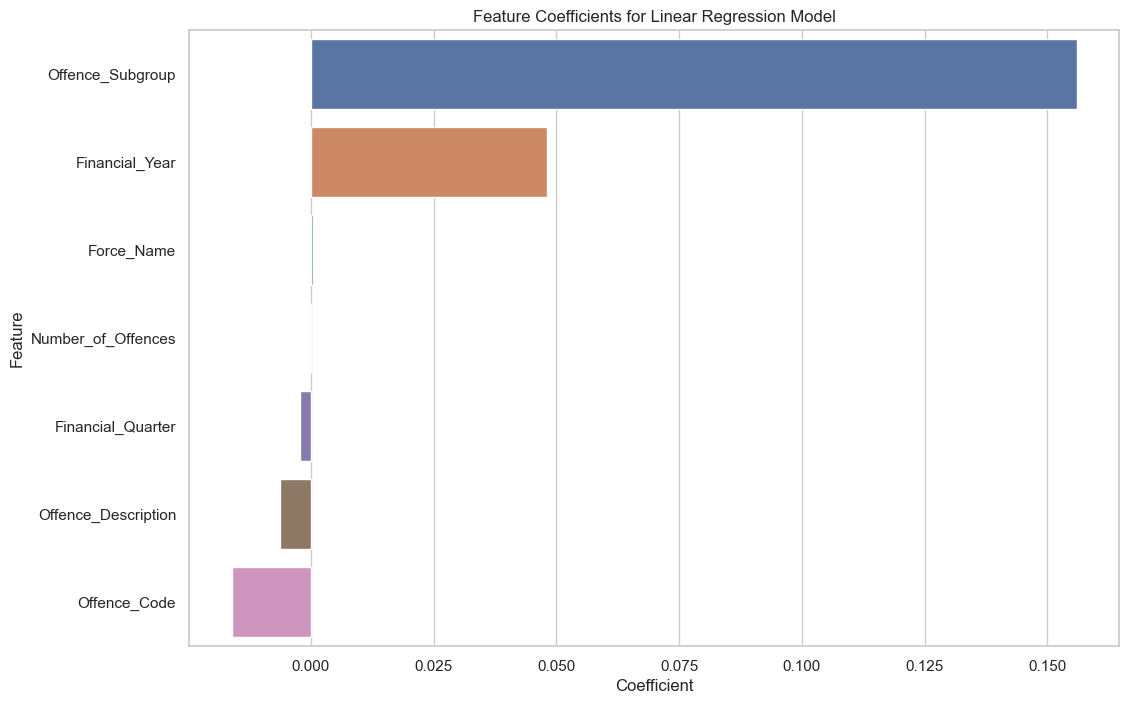

In [ ]:
coefficients = LR_model.coef_
feature_names = x_train.columns

feature_coefficients = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_coefficients = feature_coefficients.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=feature_coefficients)
plt.title('Feature Coefficients for Linear Regression Model')
plt.show()


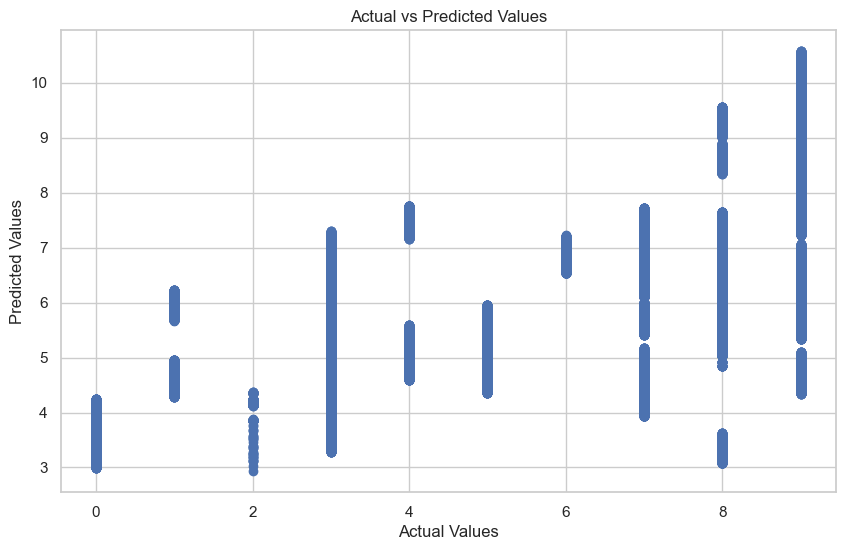

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, prediction)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()


**Report on Multiple Linear Regression for Crime Prediction**

*Introduction:*

This report presents the implementation and evaluation of a Multiple Linear Regression model for predicting crime levels based on various features. Multiple Linear Regression is a linear approach to modeling the relationship between a dependent variable and multiple independent variables. The dataset is split into training and testing sets to facilitate model training and assessment.

*Model Training:*

The Multiple Linear Regression model is instantiated and trained on the training set (`x_train`, `y_train`) using the fit method. The model optimizes coefficients to create a linear equation that best represents the relationship between the features and the target variable.

*Model Prediction:*

Once trained, the model is used to predict crime levels on the testing set (`x_test`). The predicted values (`prediction`) are compared against the actual values (`y_test`) to evaluate the model's performance.

*Performance Metrics:*

The following metrics are employed to assess the model's performance:

- **R-squared (R2):** A measure indicating the proportion of the variance in the dependent variable that is predictable from the independent variables.
- **Mean Absolute Error (MAE):** The average absolute difference between predicted and actual values.
- **Mean Squared Error (MSE):** The average of the squared differences between predicted and actual values.

*Results:*

The Multiple Linear Regression model yielded the following performance metrics on the testing set:

- **R-squared (R2):** 0.33
- **Mean Absolute Error (MAE):** 1.94
- **Mean Squared Error (MSE):** 5.35

These metrics provide insights into the explanatory power, accuracy, and precision of the model. The R-squared value indicates that approximately 33% of the variance in crime levels can be explained by the features in the model.

*Feature Coefficients:*

The coefficients associated with each feature in the model are visualized using a bar plot. This visualization highlights the impact of each feature on predicting crime levels.

*Actual vs Predicted Values:*

A scatter plot is generated to compare actual values against predicted values. This visual representation allows for a qualitative assessment of the model's predictive performance.

*Conclusion:*

In conclusion, the Multiple Linear Regression model provides a baseline understanding of the relationship between features and crime levels. The R2 value suggests a moderate level of predictive power. This analysis contributes to the application of regression models in crime prediction and societal well-being.

**XGBoost**

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

xgb_model = XGBRegressor()

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5)
grid_search.fit(x_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)


Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}


In [ ]:
Best_Hyperparameters = {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}

In [ ]:
xgb_model = XGBRegressor(**Best_Hyperparameters)
xgb_model.fit(x_train, y_train)

xgb_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
y_pred = xgb_model.predict(x_test)
y_pred[0:5]

array([7.999987 , 7.999987 , 6.9999976, 6.999995 , 6.999995 ],
      dtype=float32)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

In [ ]:
list_mse =[mse]
list_mae = [mae]

Report = pd.DataFrame(list_mse, index=['XGBoost'])
Report.columns = ['Mean Squared Error']
Report.insert(loc=1, column='Mean Absolute Error', value=list_mae)
Report.columns.name = 'Algorithm'
print(Report)

Algorithm  Mean Squared Error  Mean Absolute Error
XGBoost          5.403647e-11             0.000006


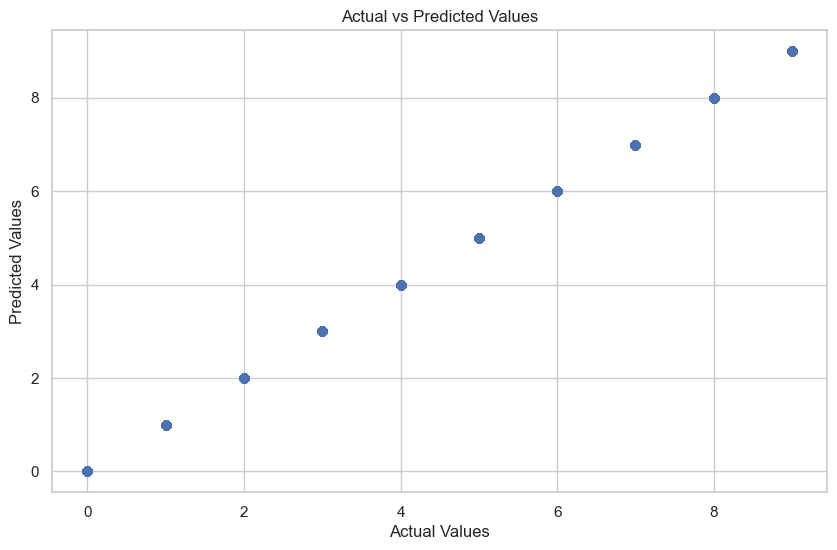

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()


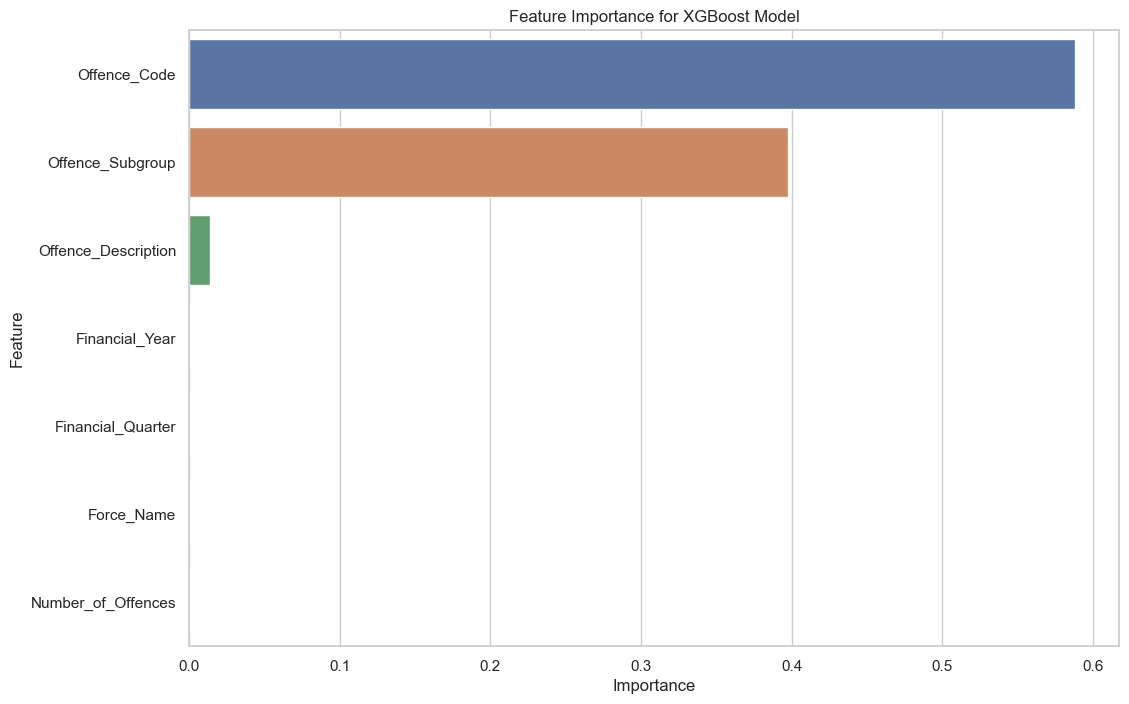

In [ ]:
importances = xgb_model.feature_importances_
features = x_train.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance for XGBoost Model')
plt.show()


**Report on XGBoost Regression for Crime Prediction**

*Introduction:*

This report outlines the implementation and evaluation of an XGBoost Regression model for predicting crime levels based on various features. XGBoost is a powerful and efficient algorithm known for its performance in regression and classification tasks. The dataset is divided into training and testing sets to facilitate model training and assessment.

*Hyperparameter Tuning:*

A grid search is conducted to find the optimal hyperparameters for the XGBoost model. The parameters explored include the number of estimators, learning rate, maximum depth of trees, and subsample ratio. The best hyperparameters obtained from the grid search are used to initialize the XGBoost model.

*Model Training and Prediction:*

The XGBoost Regression model is trained on the training set (`x_train`, `y_train`) using the fit method. Once trained, the model is used to predict crime levels on the testing set (`x_test`). The predicted values (`y_pred`) are then evaluated for model performance.

*Performance Metrics:*

The following metrics are employed to assess the performance of the XGBoost Regression model:

- **Mean Squared Error (MSE):** The average of the squared differences between predicted and actual values.
- **Mean Absolute Error (MAE):** The average absolute difference between predicted and actual values.

*Results:*

The XGBoost Regression model yielded the following performance metrics on the testing set:

- **Mean Squared Error (MSE):** 5.40e-11
- **Mean Absolute Error (MAE):** 0.000006

These extremely low error values suggest that the XGBoost model provides a highly accurate prediction of crime levels on the testing set.

*Actual vs Predicted Values:*

A scatter plot is generated to visually compare actual values against predicted values. The close alignment of points in the scatter plot further indicates the accuracy of the XGBoost model.

*Feature Importance:*

The importance of each feature in predicting crime levels is visualized using a bar plot. This plot provides insights into which features contribute the most to the model's predictions.

*Conclusion:*

In conclusion, the XGBoost Regression model demonstrates exceptional accuracy in predicting crime levels based on the selected features. The low MSE and MAE values suggest that the model provides precise and reliable predictions. The feature importance analysis can further guide understanding regarding the influential factors in predicting crime levels. This analysis contributes to the application of advanced machine learning algorithms in crime prediction tasks.